<a href="https://colab.research.google.com/github/songiangvn/AI-Machine-Learning-for-Coders/blob/main/Chapter_3_2_Going_Beyond_the_Basics_Detecting_Features_in_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Horses and Humans

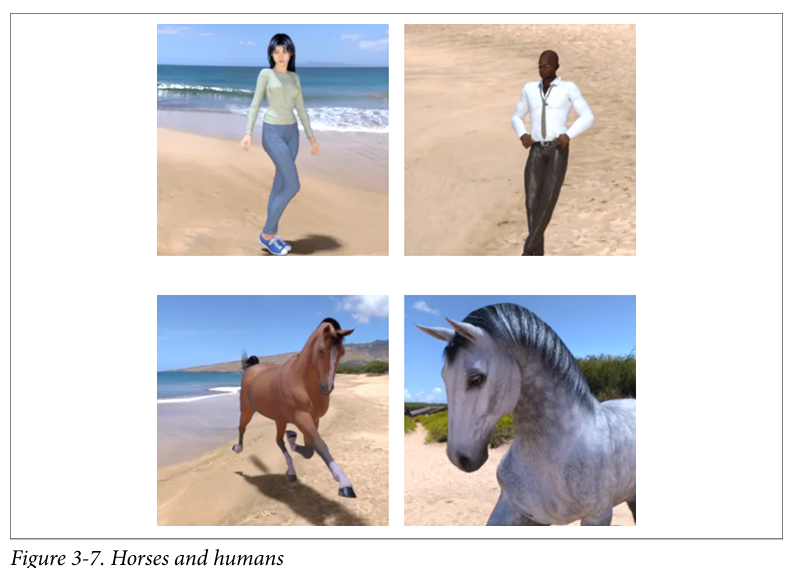

 In this section we’ll explore a more complex scenario than the Fashion MNIST
 classifier. We’ll extend what we’ve learned about convolutions and convolutional neu
ral networks to try to classify the contents of images where the location of a feature
 isn’t always in the same place

Với bộ dữ liệu này có thể thấy rằng, các bức ảnh rất đa dạng về vị trí của ngựa và người, dáng đứng khác nhau cũng như vị trí xuất hiện trong chủ thể bức ảnh sẽ bị phụ thuộc vào background nên a classifier will have to determine which
 parts of the image are the important features that determine what makes a horse a
 horse and a human a human, without being affected by the background.

# Data Preprocessing

Thông thường, các bộ dữ liệu thường được định dạng dưới dạng danh sách dữ liệu và danh sách nhãn đi kèm. Tuy nhiên, trong một số trường hợp, dữ liệu lại được chia theo cách lưu trong các folder, với tên của folder chính là nhãn tương ứng. Ví dụ như trường hợp này vậy.

Để xử lý kiểu dữ liệu này một cách thuận tiện, chúng ta sẽ làm quen với phương thức **ImageDataGenerator** từ **Keras**. Công cụ này giúp tái cấu trúc dữ liệu và tiền xử lý hình ảnh một cách dễ dàng hơn, đồng thời hỗ trợ các thao tác như tăng cường dữ liệu (**augmentation**), chuẩn hóa (**normalization**), và tạo batch để huấn luyện mô hình.

In [1]:
import urllib.request
import zipfile

# Link để download bộ dữ liệu huấn luyện horse-or-human
url = "https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip"

file_name = "horse-or-human.zip"
training_dir = "horse-or-human/training/"
urllib.request.urlretrieve(url, file_name)

# Giải nén file zip
zip_ref = zipfile.ZipFile(file_name, 'r')
zip_ref.extractall(training_dir)
zip_ref.close()

Những dòng ở bên trên là để download dữ liệu từ 1 nguồn url về trong chia thư mục rồi unzip các thứ luôn

 Bây giờ sử dụng **ImageDataGenerator** để có thể load dữ liệu từ folder thành dữ liệu có thể dễ dàng đưa vào trong model

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1/255
train_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size = (300, 300),
    class_mode = 'binary'
)

Found 1027 images belonging to 2 classes.


- train_datagen là instance của class ImageDataGenerator
- Sau đó specify nó sẽ "generate images" cho quá tình training từ thư mục nào, kích thức ảnh là bao nhiêu và mode là gì
- Ở đây bài toán chỉ có 2 loại horse và human nên là binary, còn nếu nhiều hơn 2 loại thì có thể dùng categorical

## Adding Validation to the Dataset

Sự khác biệt giữa tập hiệu chỉnh và tập kiểm tra:
Về cơ bản, tập hiệu chỉnh không khác nhiều so với tập kiểm tra, vì cả hai đều được dùng để kiểm tra mô hình. Tuy nhiên, chúng có vai trò khác nhau:

- Tập hiệu chỉnh:

 - Được sử dụng trong quá trình huấn luyện.
 - Giúp kiểm tra hiệu quả của mô hình trên dữ liệu chưa từng thấy.
 - Được dùng để hiệu chỉnh và tối ưu tham số của mô hình, chẳng hạn như điều chỉnh số lượng epoch, tốc độ học (learning rate), hoặc cấu trúc của mô hình.
- Tập kiểm tra:

 - Được sử dụng sau khi hoàn tất quá trình huấn luyện.
 - Được dùng để đánh giá hiệu quả cuối cùng của mô hình, dựa trên dữ liệu hoàn toàn mới và độc lập.

Hiểu đơn giản:
Tập hiệu chỉnh: Hỗ trợ tối ưu mô hình trong quá trình huấn luyện.
Tập kiểm tra: Đánh giá kết quả cuối cùng của mô hình.

In [3]:
# Tải bộ dữ liệu hiệu chỉnh (validation)
url = "https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip"
validation_file_name = "validation-horse-or-human.zip"
validation_dir = 'horse-or-human/validation/'
urllib.request.urlretrieve(url, validation_file_name)

zip_ref = zipfile.ZipFile(validation_file_name, 'r')
zip_ref.extractall(validation_dir)
zip_ref.close()

validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    class_mode='binary'
)

Found 256 images belonging to 2 classes.


## Building CNN Model for Horses or Humans

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer = RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Trong architecture trên:
- input_shape=(300,300,3) vì image có màu nên phải là 3 kênh màu
- Last layer chỉ có 1 neuron và có activate function là sigmoid phù hợp với bài toán binary classification

In [5]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data = validation_generator
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 348ms/step - accuracy: 0.5410 - loss: 0.7275 - val_accuracy: 0.8672 - val_loss: 0.3929
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 241ms/step - accuracy: 0.8673 - loss: 0.4001 - val_accuracy: 0.7891 - val_loss: 1.3907
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 262ms/step - accuracy: 0.9294 - loss: 0.1973 - val_accuracy: 0.7773 - val_loss: 1.4320
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 0.9489 - loss: 0.1509 - val_accuracy: 0.7539 - val_loss: 1.5559
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.9739 - loss: 0.0995 - val_accuracy: 0.8906 - val_loss: 0.6075
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - accuracy: 0.9901 - loss: 0.0476 - val_accuracy: 0.8125 - val_loss: 1.2634
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 0.9866 - loss: 0.0662 - val_accuracy: 0.8320 - val_loss: 1.2929
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 0.9823 - loss: 0.0439 - val_accuracy: 0.8555 - 

After training for 15 epochs, you should see that your model is 99%+ accurate on the
 training set, but only about 83% on the validation set. This is an indication that the
 model is overfitting, as we saw in the previous chapter.

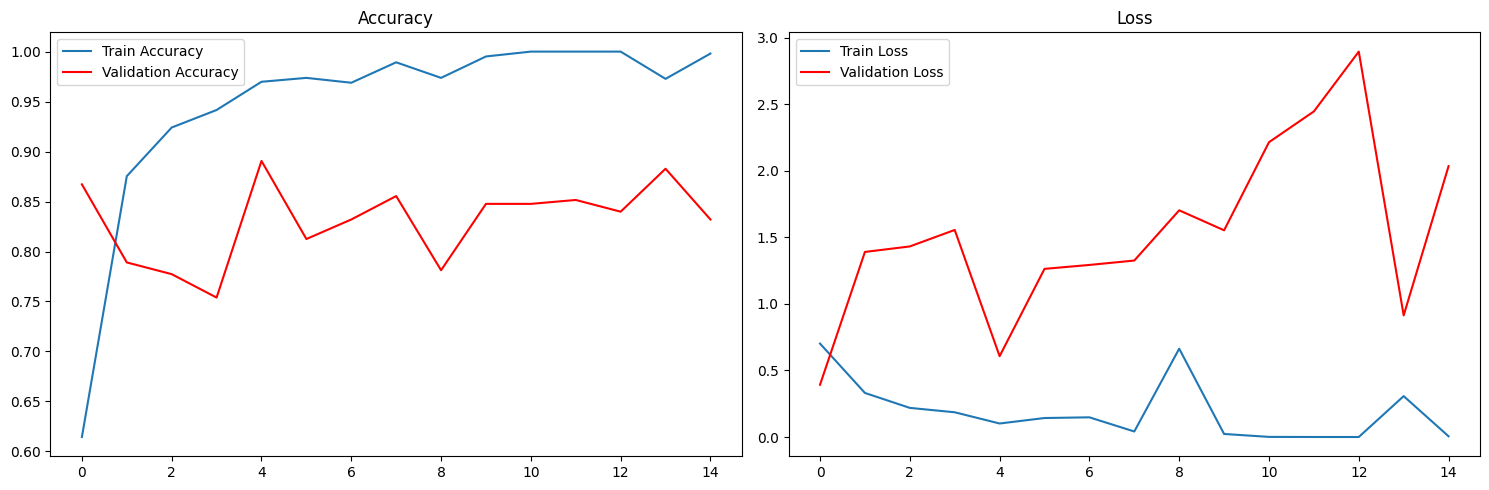

In [7]:
import matplotlib.pyplot as plt
# Vẽ biểu đồ đánh giá quá trình train trên 15 epochs

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(acc, label='Train Accuracy')
axs[0].plot(val_acc, label='Validation Accuracy', color = 'red')
axs[0].set_title('Accuracy')
axs[0].legend()
axs[1].plot(loss, label='Train Loss')
axs[1].plot(val_loss, label='Validation Loss', color = 'red')
axs[1].set_title('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

Như mọi người thấy đấy, đường màu xanh đại diện cho dữ liệu trên tập huấn luyện, nhìn qua thì có vẻ rất "yên bình", không có nhiều biến động. Nhưng khi nhìn sang đường màu đỏ đại diện cho tập hiệu chỉnh (validation), ta mới thấy được sự "sóng gió" thật sự :v.

Điều này thể hiện rõ khả năng hoạt động thực sự của mô hình trên dữ liệu chưa từng biết đến hay nhìn thấy trước đó

In [8]:
# Kết quả đánh giá trên tập val
result = model.evaluate(validation_generator)
for i,m in enumerate(model.metrics_names):
  print(f"Kết quả đánh giá {m} trên tập val: {result[i]}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.8350 - loss: 2.2022
Kết quả đánh giá loss trên tập val: 2.0352330207824707
Kết quả đánh giá compile_metrics trên tập val: 0.83203125


## Kiểm tra và trực quen kết quả trên tập Validation

A
 major frustration of mine when I was starting my AI journey was that I could find
 lots of code that showed me how to build models, and charts of how those models
 were performing, but very rarely was there code to help me kick the tires of the
 model myself to try it out. I’ll try to avoid that in this book!

 Quan trọng là "thử nghiệm mô hình"


In [9]:
# Chú ý ở đây ta có một chút thay đổi, vì lệnh ImageDataGenerator
# trước đó của ta chưa tắt shuffle nên thứ tự nhãn sẽ bị lệch,
# tuy rằng với evaluate mô hình vẫn có thể chạy đúng
# nhưng với predict thì mô hình lại hoạt động theo thứ tự khác
# do đó ta cần tắt shuffle đi.

validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    class_mode='binary',
    shuffle=False  # Tắt shuffle
)

Found 256 images belonging to 2 classes.


In [11]:
import numpy as np
# Chuyển sigmoid đầu ra thành nhãn nhị phân
y_pred = (model.predict(validation_generator) > 0.5).astype(int).flatten()

# Nhãn thực tế từ generator
y_true = validation_generator.classes

# Kiểm tra độ chính xác
accuracy = np.mean(y_pred == y_true)
print(f"Accuracy (manual): {accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
Accuracy (manual): 83.20%


Số ảnh bị sai:  43


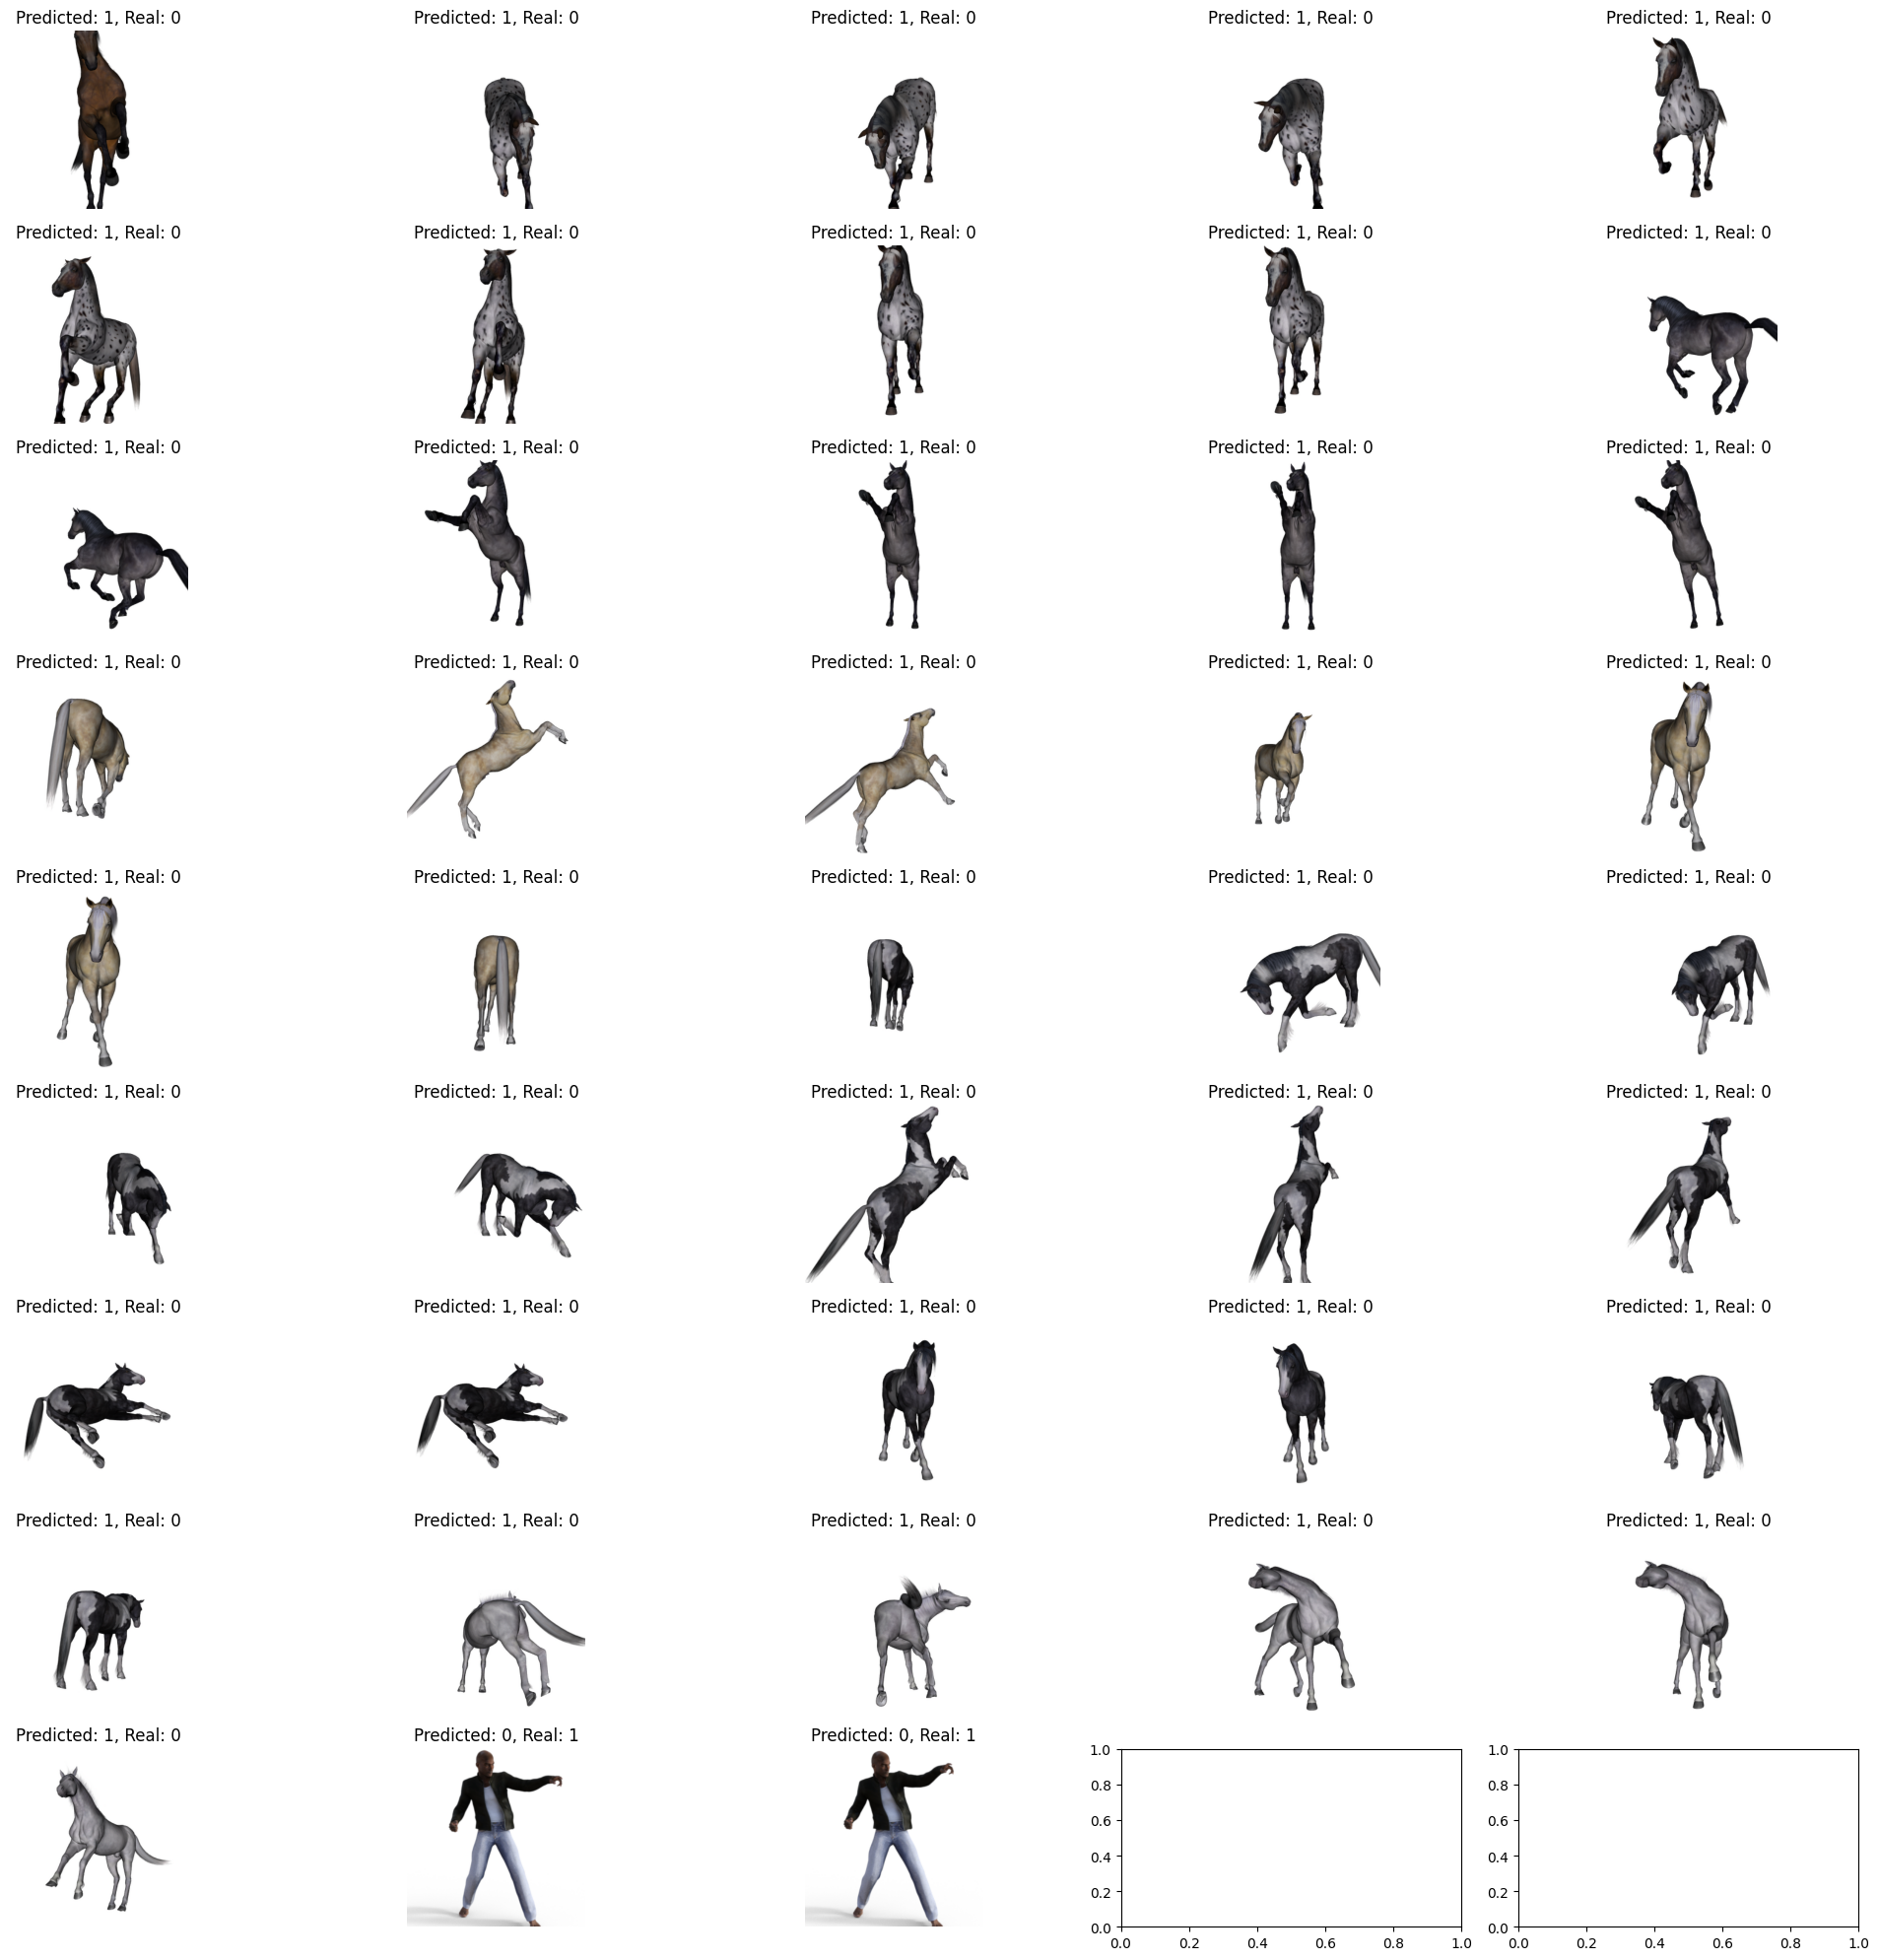

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Lấy đường dẫn file và hình ảnh từ generator
filepaths = validation_generator.filepaths

# Tìm các ảnh bị dự đoán sai
incorrect_indices = np.where(y_pred != y_true)[0]  # Chỉ số ảnh bị sai
print("Số ảnh bị sai: ", len(incorrect_indices))

incorrect_filepaths = [filepaths[i] for i in incorrect_indices]

# Hiển thị ảnh bị dự đoán sai
n_cols = 5

# Tính số hàng của biểu đồ một cách linh động
if len(incorrect_indices) % n_cols == 0:
    n_rows = len(incorrect_indices) // n_cols
else:
    n_rows = len(incorrect_indices) // n_cols + 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
axs = axs.flatten()

for i, idx in enumerate(incorrect_indices):  # Hiển thị các ảnh sai
    # Đọc ảnh từ đường dẫn
    img = plt.imread(filepaths[idx])
    axs[i].imshow(img)
    axs[i].set_title(f"Predicted: {y_pred[idx]}, Real: {y_true[idx]}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


Mọi người có thể thấy sẽ có một vài tấm ảnh con ngựa có dáng đứng đặc biệt, chẳng hạn như hướng dọc đối diện về phía trước, có thể bị dự đoán sai vì nhìn giống tư thế đứng của con người. Tương tự, một vài tấm ảnh con người mặc áo quần có màu sắc gần giống màu của ngựa cũng có thể gây nhầm lẫn trong quá trình dự đoán

## Testing

In [17]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

# Danh sách để lưu kết quả dự đoán
predicted_result = []

uploaded = files.upload()

for fn in uploaded.keys():
  # Lấy đường dẫn hình ảnh
  path = '/content/' + fn

  # Tiến hành lấy dữ liệu hình ảnh
  # Ảnh up lên có thể có nhiều kích thước khác nhau nên mình cần xác định lại về đúng kích thước đầu vào của mô hình (300 x 300).
  img = image.load_img(path, target_size = (300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  # Dự đoán hình ảnh
  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  pred_label = 0 if classes[0] < 0.5 else 1

  if pred_label == 1:
    print(f"Kết quả dự đoán {fn} là người.")
  else:
    print(f"Kết quả dự đoán {fn} là ngựa.")

  predicted_result.append([img, pred_label])


Saving human4.jpg to human4.jpg
Saving human3.jpg to human3.jpg
Saving human2.jpg to human2.jpg
Saving human1.jpg to human1.jpg
Saving horse4.jpg to horse4.jpg
Saving horse3.jpg to horse3.jpg
Saving horse2.jpg to horse2.jpg
Saving horse1.jpg to horse1 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Kết quả dự đoán human4.jpg là ngựa.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Kết quả dự đoán human3.jpg là người.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Kết quả dự đoán human2.jpg là người.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Kết quả dự đoán human1.jpg là ngựa.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Kết quả dự đoán horse4.jpg là ngựa.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Kết quả dự đoán horse3.jpg là người.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Kết quả dự đoán horse2.jpg là người.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Kết quả dự đoán horse1 (1).jpg là ngựa.


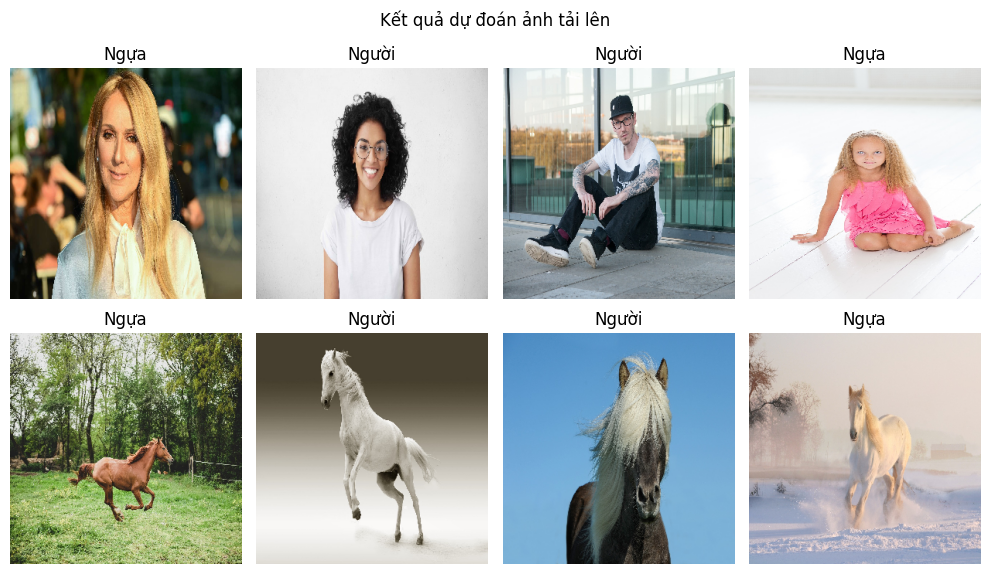

In [18]:
# Trực quan hình ảnh và kết quả dự đoán
n_imgs = len(predicted_result)
n_cols = 4
# Tính số hàng một cách linh động
if n_imgs % n_cols == 0:
  n_rows = n_imgs // n_cols
else:
  n_rows = n_imgs // n_cols + 1

fig, axs = plt.subplots(n_rows, n_cols, figsize = (10, 6))
axs = axs.flatten()
for i in range(n_imgs):
  axs[i].imshow(predicted_result[i][0])
  pred_label = "Người" if predicted_result[i][1] == 1 else "Ngựa"
  axs[i].set_title(pred_label)
  axs[i].axis('off')

fig.suptitle("Kết quả dự đoán ảnh tải lên")

plt.tight_layout()
plt.show()

In [21]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

# Danh sách để lưu kết quả dự đoán
predicted_result = []

uploaded = files.upload()

for fn in uploaded.keys():
  # Lấy đường dẫn hình ảnh
  path = '/content/' + fn

  # Tiến hành lấy dữ liệu hình ảnh
  # Ảnh up lên có thể có nhiều kích thước khác nhau nên mình cần xác định lại về đúng kích thước đầu vào của mô hình (300 x 300).
  img = image.load_img(path, target_size = (300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  # Dự đoán hình ảnh
  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  pred_label = 0 if classes[0] < 0.5 else 1

  if pred_label == 1:
    print(f"Kết quả dự đoán {fn} là người.")
  else:
    print(f"Kết quả dự đoán {fn} là ngựa.")

  predicted_result.append([img, pred_label])


Saving jack.jpg to jack.jpg
Saving ronaldo.jpg to ronaldo.jpg
Saving messi.jpg to messi.jpg
Saving manh.jpg to manh (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Kết quả dự đoán jack.jpg là ngựa.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Kết quả dự đoán ronaldo.jpg là ngựa.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Kết quả dự đoán messi.jpg là ngựa.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Kết quả dự đoán manh (1).jpg là ngựa.


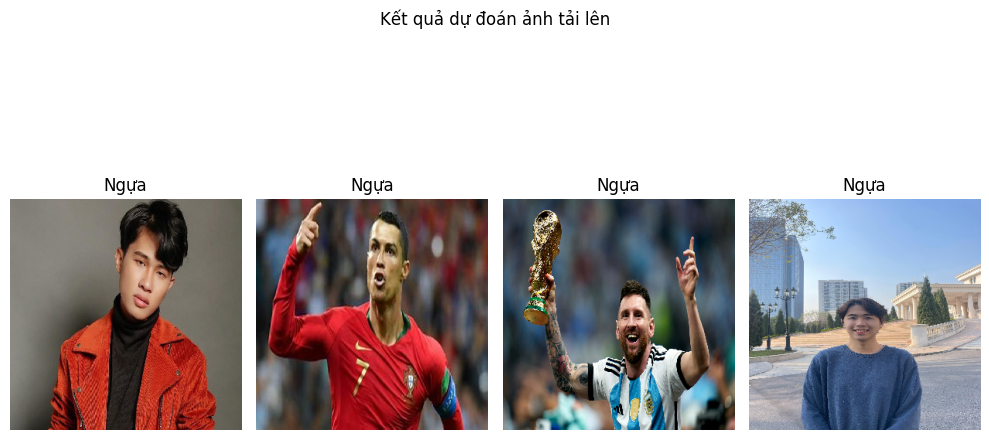

In [22]:
# Trực quan hình ảnh và kết quả dự đoán
n_imgs = len(predicted_result)
n_cols = 4
# Tính số hàng một cách linh động
if n_imgs % n_cols == 0:
  n_rows = n_imgs // n_cols
else:
  n_rows = n_imgs // n_cols + 1

fig, axs = plt.subplots(n_rows, n_cols, figsize = (10, 6))
axs = axs.flatten()
for i in range(n_imgs):
  axs[i].imshow(predicted_result[i][0])
  pred_label = "Người" if predicted_result[i][1] == 1 else "Ngựa"
  axs[i].set_title(pred_label)
  axs[i].axis('off')

fig.suptitle("Kết quả dự đoán ảnh tải lên")

plt.tight_layout()
plt.show()

Bạn có thể thấy những tấm ảnh mình kiểm tra hầu hết đều bị cắt một nửa hoặc chỉ lấy một phần bộ phận cơ thể. Với những tấm ảnh về người, hầu hết đều bị dự đoán sai. Điều này có thể do:

1. Dữ liệu trong quá trình huấn luyện thiếu sót các trường hợp đặc biệt, chẳng hạn như ảnh chỉ chứa một phần cơ thể hoặc ảnh bị cắt góc.
2. Số lượng mẫu chưa đủ nhiều, dẫn đến mô hình chưa thể khái quát hóa tốt các trường hợp đa dạng

What’s the solution? The obvious one is to add more training data, with humans in
 that particular pose and others that weren’t initially represented. That isn’t always
 possible, though. Fortunately, there’s a neat trick in TensorFlow that you can use to
 virtually extend your dataset—it’s called image augmentation, and we’ll explore that
 next.

# Image Augmentation

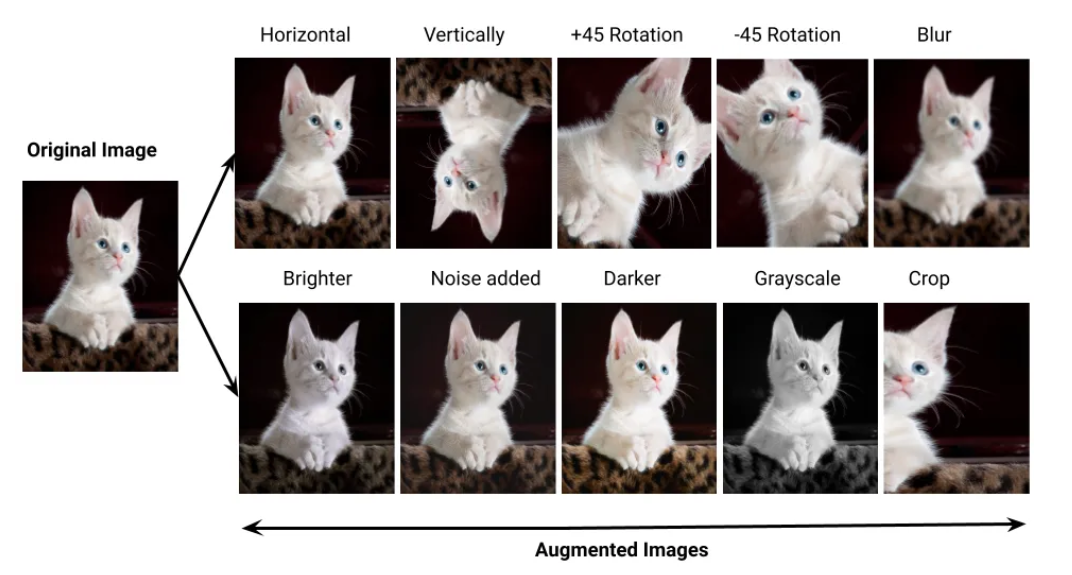

As a result, you soon began to hit problems classifying
 some previously unseen images, such as the miscategorization of a woman with a
 horse because the training set didn’t include any images of people in that pose.
 One way to deal with such problems is with image augmentation. The idea behind
 this technique is that, as TensorFlow is loading your data, it can create additional new
 data by amending what it has using a number of transforms.

For example, take a look
 at Figure 3-11. While there is nothing in the dataset that looks like the woman on the
 right, the image on the left is somewhat similar

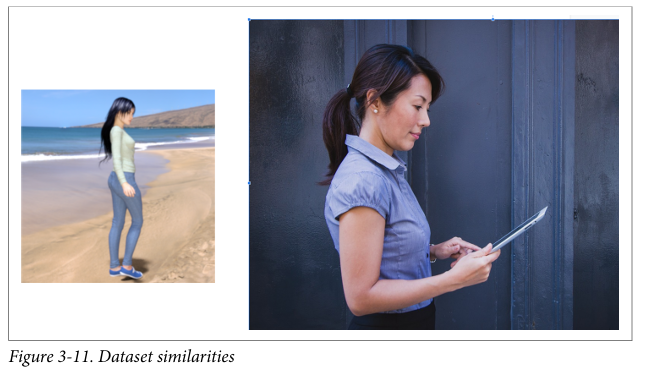

Ví dụ nếu crop hình ảnh input vào thì nhìn có vẻ giống cái ảnh thật ở bên phải

 In a similar way, you can broaden the training set with a variety of other transformations, including:
- Rotation
- Shifting horizontally
- Shifting vertically
- Shearing
- Zooming
- Flipping

## Retrain with Image Augmentation

In [23]:
import urllib.request
import zipfile

# Link để download bộ dữ liệu huấn luyện horse-or-human
url = "https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip"

file_name = "horse-or-human.zip"
training_dir = "horse-or-human/training/"
urllib.request.urlretrieve(url, file_name)

# Giải nén file zip
zip_ref = zipfile.ZipFile(file_name, 'r')
zip_ref.extractall(training_dir)
zip_ref.close()

In [24]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40, # Xoay ngẫu nhiên từ 0 đến 40 độ qua trái hoặc phải
    width_shift_range = 0.2, # Dịch hình ảnh qua trái hoặc phải từ 0 đến 20%
    height_shift_range = 0.2, # Dịch hình ảnh lên xuống từ 0 đến 20%
    shear_range = 0.2, # Cắt nghiên hình ảnh từ 0 đến 20%
    zoom_range = 0.2, # Phóng to, thu nhỏ hình ảnh ngẫu nhiên từ 0 đến 20%
    horizontal_flip = True, # Lật ngang hình ảnh
    fill_mode = 'nearest' # Các pixel mới được tạo ra dựa trên cấc pixel gần nhất
)

Create Training Set

In [25]:
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(300, 300),
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.


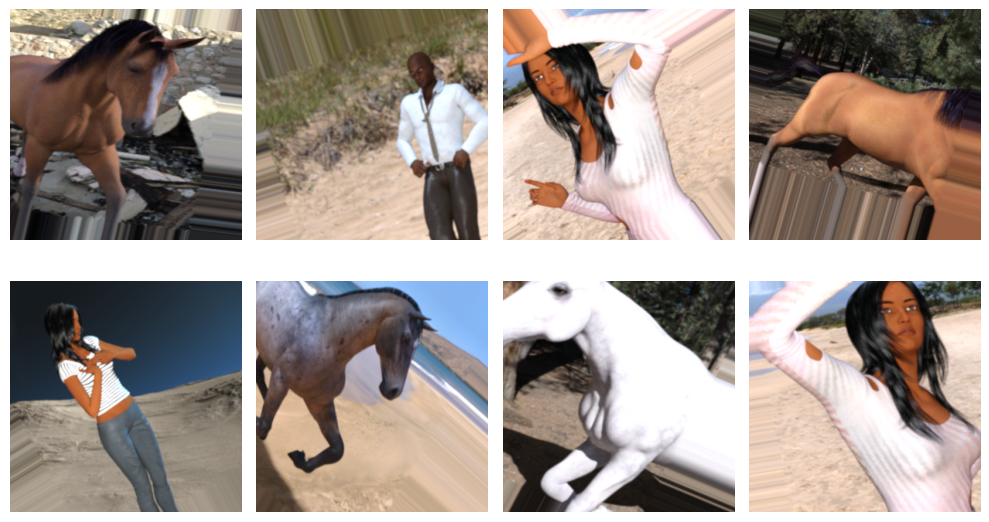

In [26]:
# Xem 8 ảnh đầu tiên
fig, axs = plt.subplots(2, 4, figsize = (10, 6))
axs = axs.flatten()
for i in range(len(axs)):
  axs[i].imshow(train_generator[0][0][i])
  axs[i].axis('off')

plt.tight_layout()
plt.show()

In [27]:
# Tải bộ dữ liệu hiệu chỉnh (validation)
url = "https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip"
validation_file_name = "validation-horse-or-human.zip"
validation_dir = 'horse-or-human/validation/'
urllib.request.urlretrieve(url, validation_file_name)

zip_ref = zipfile.ZipFile(validation_file_name, 'r')
zip_ref.extractall(validation_dir)
zip_ref.close()

validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    class_mode='binary'
)


Found 256 images belonging to 2 classes.


In [28]:
# Định nghĩa mô hình, mô hình này cũng giống mô hình trước đó à,
# mình viết lại nếu trong trường hợp các bạn muốn bắt đầu huấn luyện luôn từ bước này
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer = RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data = validation_generator
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 664ms/step - accuracy: 0.4972 - loss: 0.7071 - val_accuracy: 0.5000 - val_loss: 0.6899
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 39s 673ms/step - accuracy: 0.5716 - loss: 0.6915 - val_accuracy: 0.5312 - val_loss: 0.6622
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 648ms/step - accuracy: 0.6986 - loss: 0.5911 - val_accuracy: 0.6641 - val_loss: 0.9574
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 660ms/step - accuracy: 0.6836 - loss: 0.5886 - val_accuracy: 0.7969 - val_loss: 0.5475
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 654ms/step - accuracy: 0.7682 - loss: 0.5051 - val_accuracy: 0.5859 - val_loss: 3.0175
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 671ms/step - accuracy: 0.7945 - loss: 0.4551 - val_accuracy: 0.6797 - val_loss: 1.6135
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 647ms/step - accuracy: 0.8219 - loss: 0.4400 - val_accuracy: 0.5625 - val_loss: 3.0458
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 662ms/step - accuracy: 0.8583 - loss: 0.3165 - val_accuracy: 0.742

When you retrain with these parameters, one of the first things you’ll notice is that
 training takes longer because of all the image processing. Also, your model’s accuracy
 may not be as high as it was previously, because previously it was overfitting to a
 largely uniform set of data

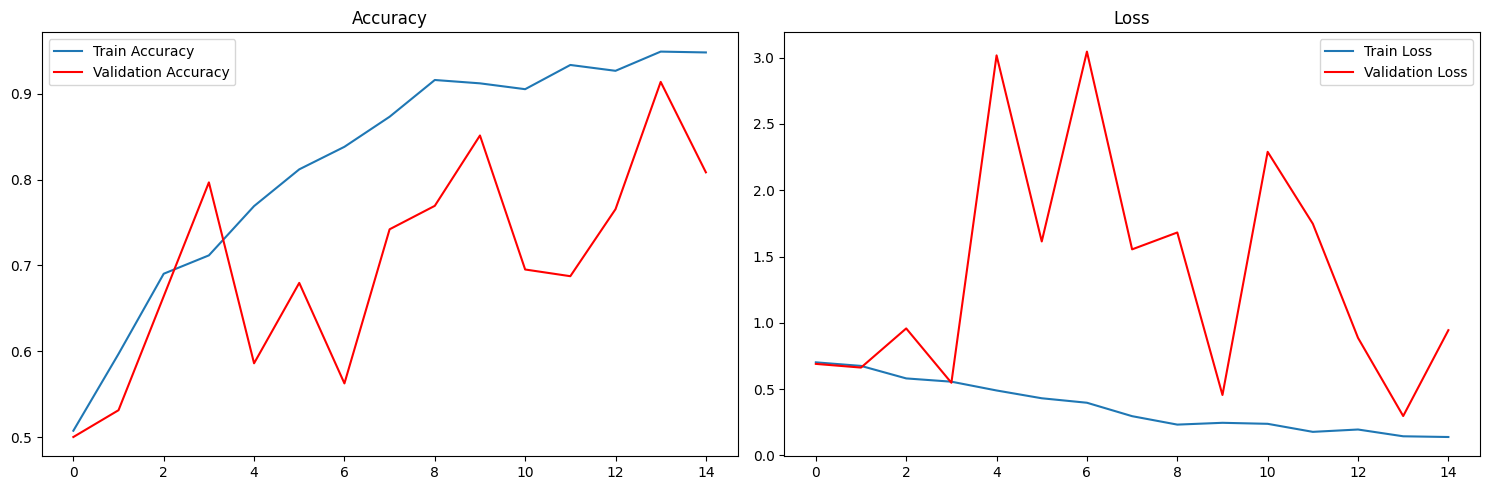

In [30]:
# Vẽ biểu đồ đánh giá quá trình train trên 15 epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(acc, label='Train Accuracy')
axs[0].plot(val_acc, label='Validation Accuracy', color = 'red')
axs[0].set_title('Accuracy')
axs[0].legend()
axs[1].plot(loss, label='Train Loss')
axs[1].plot(val_loss, label='Validation Loss', color = 'red')
axs[1].set_title('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [31]:
# Kết quả đánh giá trên tập val
result = model.evaluate(validation_generator)
for i,m in enumerate(model.metrics_names):
  print(f"Kết quả đánh giá {m} trên tập val: {result[i]}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.7935 - loss: 0.9275
Kết quả đánh giá loss trên tập val: 0.9442367553710938
Kết quả đánh giá compile_metrics trên tập val: 0.80859375


In [33]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

# Danh sách để lưu kết quả dự đoán
predicted_result = []

uploaded = files.upload()

for fn in uploaded.keys():
  # Lấy đường dẫn hình ảnh
  path = '/content/' + fn

  # Tiến hành lấy dữ liệu hình ảnh
  # Ảnh up lên có thể có nhiều kích thước khác nhau nên mình cần xác định lại về đúng kích thước đầu vào của mô hình (300 x 300).
  img = image.load_img(path, target_size = (300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  # Dự đoán hình ảnh
  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  pred_label = 0 if classes[0] < 0.5 else 1

  if pred_label == 1:
    print(f"Kết quả dự đoán {fn} là người.")
  else:
    print(f"Kết quả dự đoán {fn} là ngựa.")

  predicted_result.append([img, pred_label])

Saving jack.jpg to jack (2).jpg
Saving ronaldo.jpg to ronaldo (2).jpg
Saving messi.jpg to messi (1).jpg
Saving manh.jpg to manh (2).jpg
Saving human4.jpg to human4 (1).jpg
Saving human3.jpg to human3 (1).jpg
Saving human2.jpg to human2 (1).jpg
Saving human1.jpg to human1 (1).jpg
Saving horse4.jpg to horse4 (1).jpg
Saving horse3.jpg to horse3 (1).jpg
Saving horse2.jpg to horse2 (1).jpg
Saving horse1.jpg to horse1 (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Kết quả dự đoán jack (2).jpg là người.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Kết quả dự đoán ronaldo (2).jpg là ngựa.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Kết quả dự đoán messi (1).jpg là ngựa.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Kết quả dự đoán manh (2).jpg là người.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Kết quả dự đoán human4 (1).jpg là ngựa.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Kết quả dự đoán human3 (1).jpg là người.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Kết quả dự đoán human2 (1).jpg là người.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17

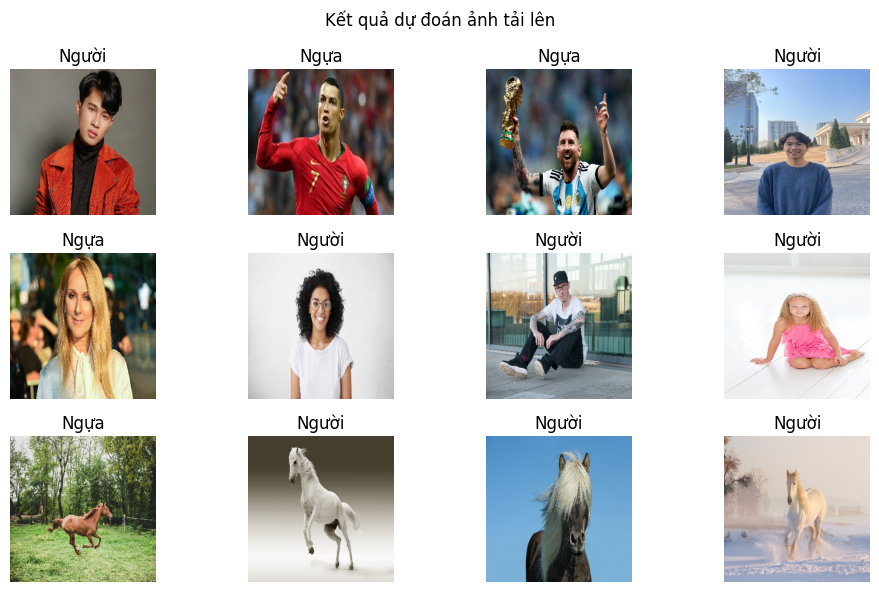

In [34]:
# Trực quan hình ảnh và kết quả dự đoán
n_imgs = len(predicted_result)
n_cols = 4
# Tính số hàng một cách linh động
if n_imgs % n_cols == 0:
  n_rows = n_imgs // n_cols
else:
  n_rows = n_imgs // n_cols + 1

fig, axs = plt.subplots(n_rows, n_cols, figsize = (10, 6))
axs = axs.flatten()
for i in range(n_imgs):
  axs[i].imshow(predicted_result[i][0])
  pred_label = "Người" if predicted_result[i][1] == 1 else "Ngựa"
  axs[i].set_title(pred_label)
  axs[i].axis('off')

fig.suptitle("Kết quả dự đoán ảnh tải lên")

plt.tight_layout()
plt.show()

Phiên mô hình lần này, mình chỉ sử dụng các hình ảnh đã được biến đổi để huấn luyện. Mọi người cũng có thể kết hợp với tập hình ảnh gốc ban đầu để có thêm nhiều dữ liệu hơn rồi huấn luyện, có thể kết quả sẽ còn cao hơn nữa.

# Tổng kết về phương pháp tăng cường hình ảnh (image augmentation)
Là phương pháp thông qua các phép biến đổi hình ảnh như xoay, cắt, làm nhiễu, lật, phóng to, thu nhỏ,... để tạo ra được nhiều hình ảnh đa dạng hơn, từ đó có thể gia tăng dữ liệu cho mô hình học tập.